In [22]:
%matplotlib notebook
import numpy as np
import emlddmm
import json
import nrrd
import os
import imp
imp.reload(emlddmm)

<module 'emlddmm' from '/mnt/data/csh_data/emlddmm/emlddmm.py'>

In [23]:
# note slices are 14.72
# 14.72*4 = 58.88 # corresponds to atlas downsampling 1
# 14.72*7 = 103.04 # atlas downsampling 2
# 14.72*14 = 206.08 # downsampling 4

In [24]:
# code to do
# common interface for load images
# make sure all fields in input datasets are read correctly
# command line interface
# preprocessing (here we are doing downsampling)
# apply transforms to other data
# profiling (optional profiling?)
# check metrics for gradient descent and update

# release to do
# readme page
# license
# documentation: 
# * explain mandatory inputs
# * explain config file
# * explain dataset format
# * explain output format

In [25]:
# todo
# finish command line interface
# finish vtk io (done)
# add slice by slice tform
# check outputs
# double check whole brain works

In [ ]:
# get whole brain working
# add tool for applying transforms
# visualization in reconstructed space during reg
# fix up vector

In [26]:
atlas_name = '/home/dtward/data/AllenInstitute/allen_vtk/ara_nissl_50.vtk'
label_name = '/home/dtward/data/AllenInstitute/allen_vtk/annotation_50.vtk'
target_name = '../microscopy_v2/microscopy/'
config_file = 'config787.json'
output_dir = 'test_outputs/'

In [27]:
with open(config_file) as f:
    config = json.load(f)
# I'm getting this for initial downsampling for preprocessing
downJs = config['downJ']

In [ ]:
# atlas test
imp.reload(emlddmm)
xI,I,title,names = emlddmm.read_vtk_data(atlas_name)
I = I.astype(float)
fig = emlddmm.draw(I,xI)
fig[0].suptitle('Atlas image')

<IPython.core.display.Javascript object>


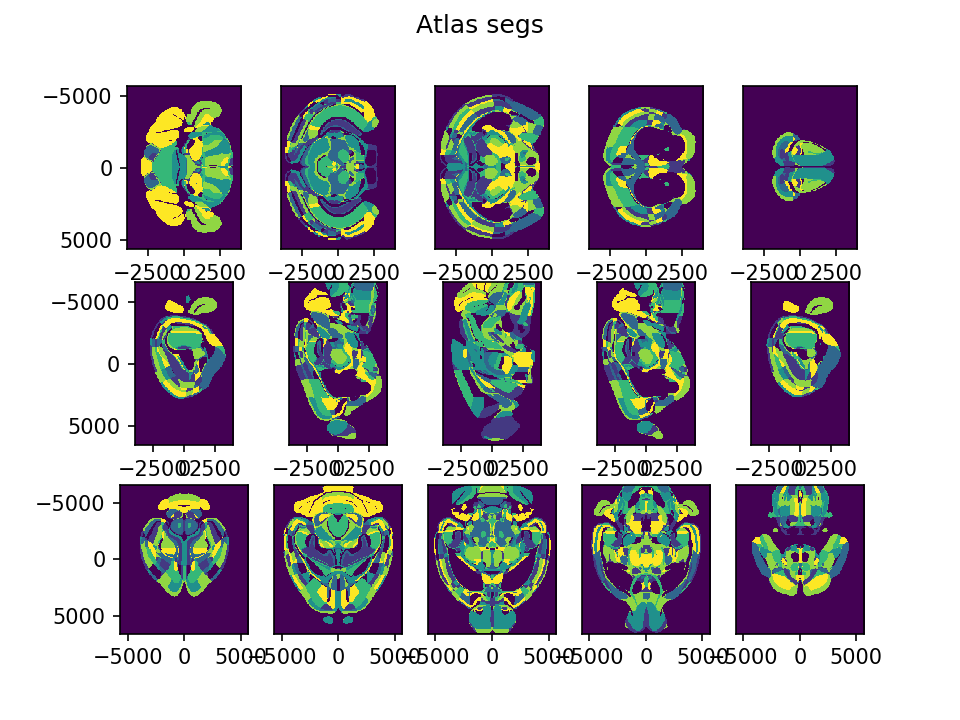

Text(0.5, 0.98, 'Atlas segs')

In [29]:
xS,S,title,names = emlddmm.read_vtk_data(label_name)
fig = emlddmm.draw(S%7,xS)
fig[0].suptitle('Atlas segs')

loading target images


<IPython.core.display.Javascript object>


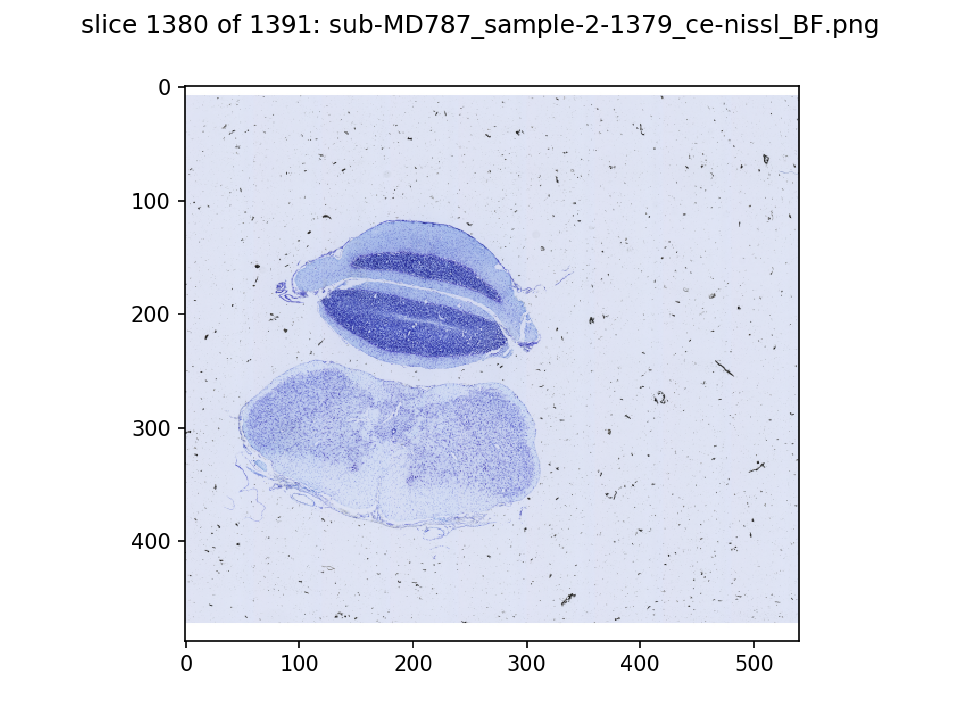

padding and assembling into 3D volume


In [30]:
xJ,J,W0 = emlddmm.load_slices(target_name)
nJ = np.array(J.shape)
dJ = np.array([xJ[0][1]-xJ[0][0], xJ[1][1]-xJ[1][0],xJ[2][1]-xJ[2][0]])

In [31]:
# initial downsampling so there isn't so much on the gpu
mindownJ = np.min(np.array(downJs),0)
xJ,J = emlddmm.downsample_image_domain(xJ,J,mindownJ)
W0 = emlddmm.downsample(W0,mindownJ)
downJs = [ (np.array(d)/mindownJ).astype(int) for d in downJs]
dJ = np.array((xJ[0][1]-xJ[0][0],xJ[1][1]-xJ[1][0],xJ[2][1]-xJ[2][0]))
nJ = np.array(J.shape,dtype=int)
# update our config variable
config['downJ'] = downJs

In [32]:
emlddmm.draw(J,xJ)

<IPython.core.display.Javascript object>

(<Figure size 640x480 with 15 Axes>,
 [[<matplotlib.axes._subplots.AxesSubplot at 0x7f5773611910>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7f577b115550>]])

In [33]:
imp.reload(emlddmm)
# visualize initial affine
A = np.array(config['A']).astype(float)
# this affine matrix should be 4x4, but it may be 1x4x4
if A.ndim > 2:
    A = A[0]
Ai = np.linalg.inv(A)
XJ = np.stack(np.meshgrid(*xJ,indexing='ij'),-1)
Xs = (Ai[:3,:3]@XJ[...,None])[...,0] + Ai[:3,-1]
out = emlddmm.interp(xI,I,Xs.transpose((3,0,1,2)))
fig = emlddmm.draw(out,xJ)
fig[0].suptitle('Initial transformed atlas')

<IPython.core.display.Javascript object>

Text(0.5, 0.98, 'Initial transformed atlas')

In [15]:
# we need to be able to compose transforms and get a final sample space
# the inputs need to be either position fields
# or matrices

In [ ]:

device = 'cpu'
device = 'cuda:1'

output = emlddmm.emlddmm_multiscale(I=I,xI=[xI],J=J,xJ=[xJ],W0=W0,device=device,**config)

In [17]:
imp.reload(emlddmm)
emlddmm.write_transform_outputs(output_dir,output)

cpu
output dir is test_outputs/qc/


<IPython.core.display.Javascript object>


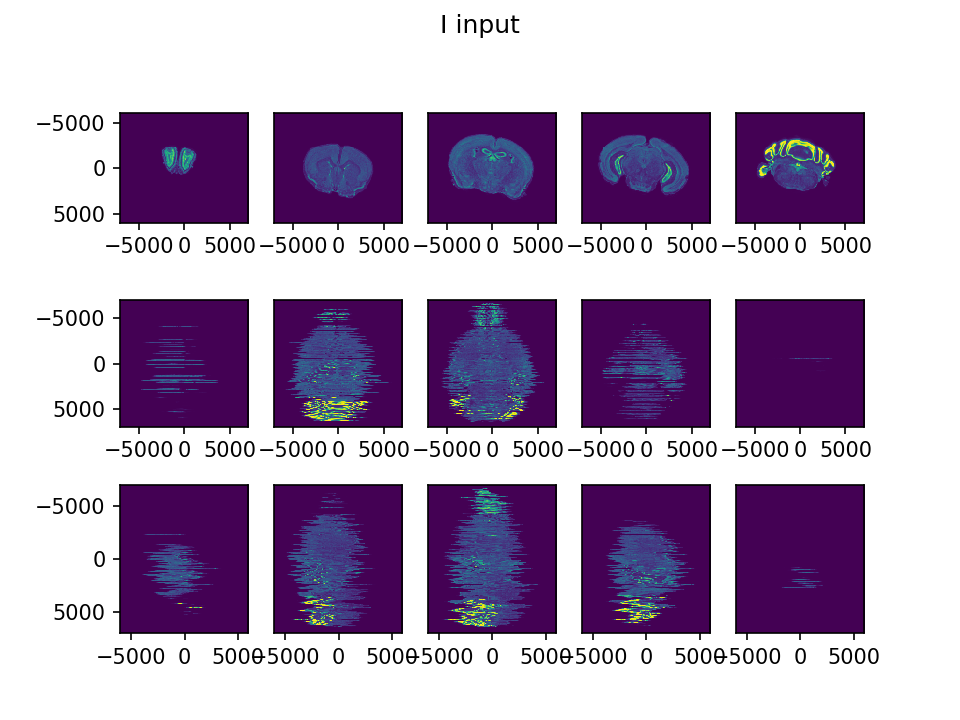

<IPython.core.display.Javascript object>


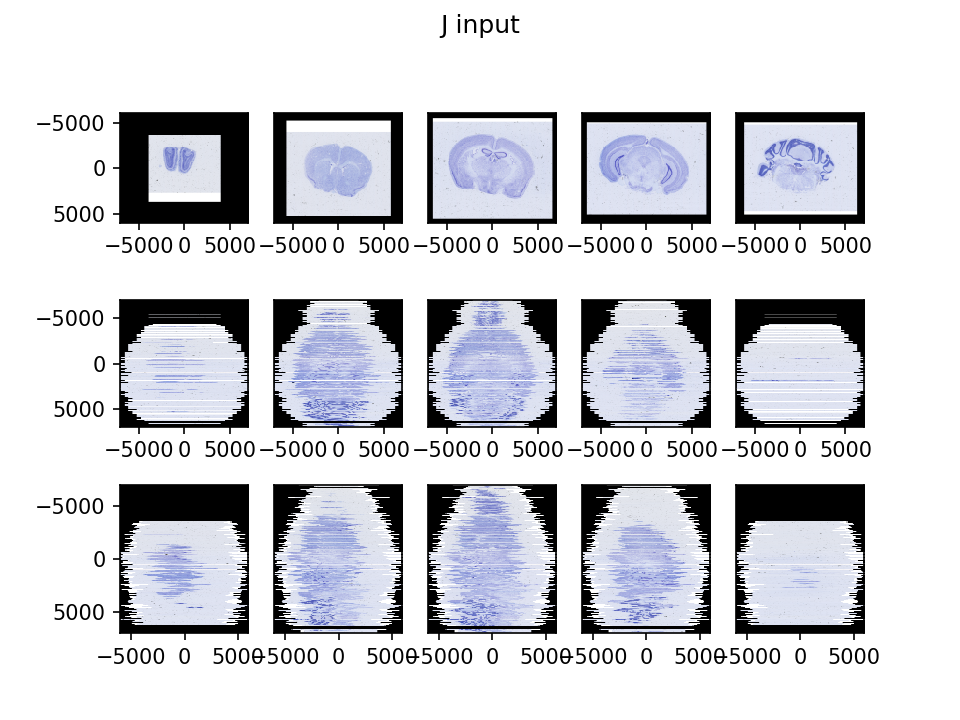

<IPython.core.display.Javascript object>


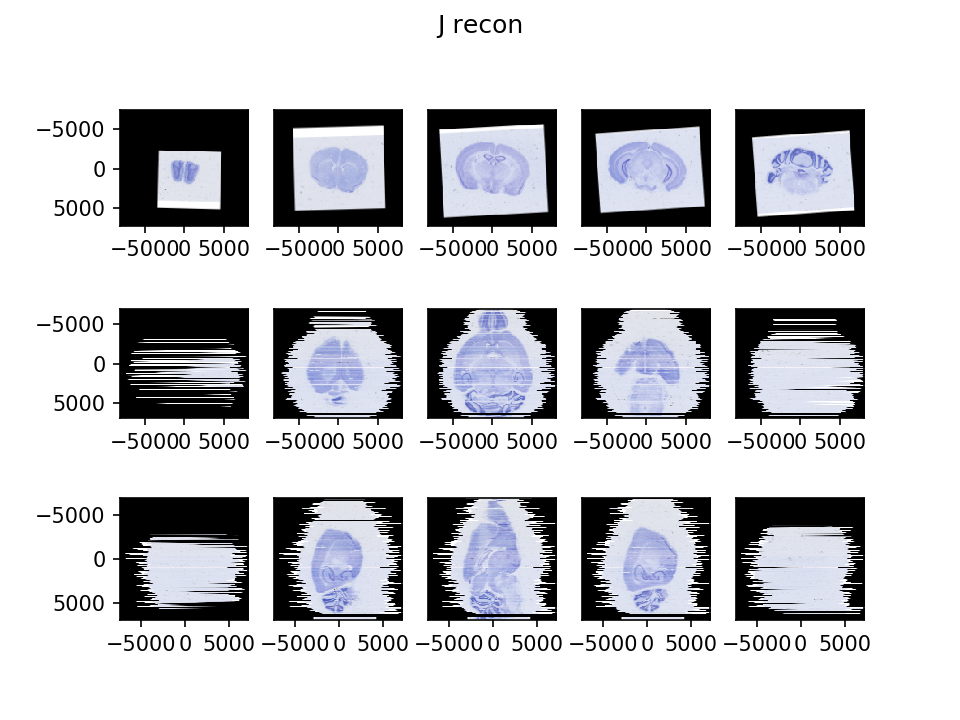

<IPython.core.display.Javascript object>


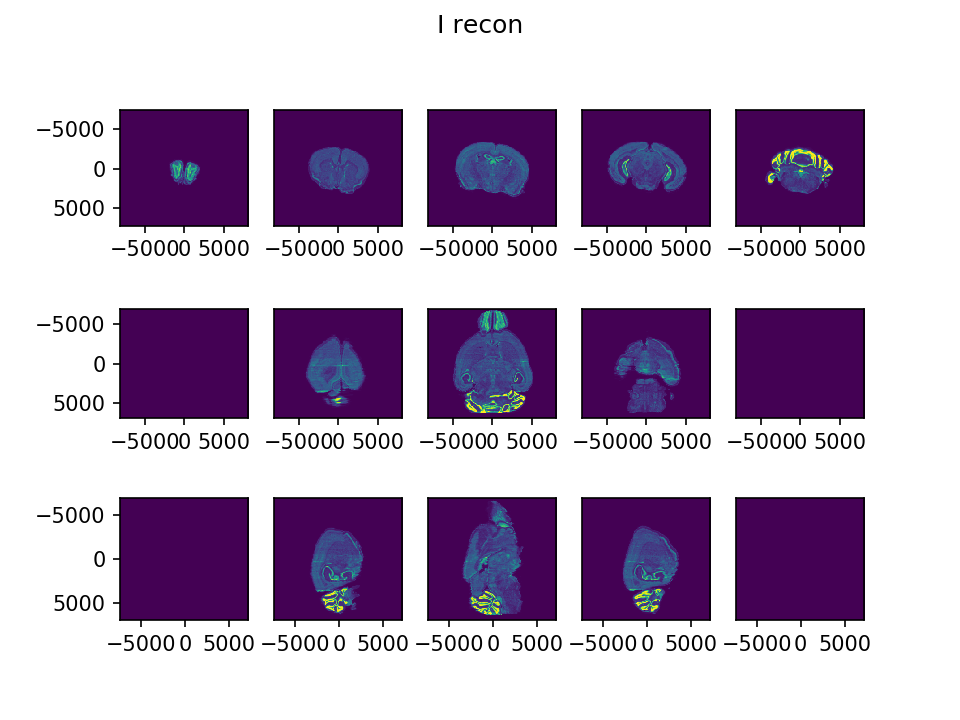

<IPython.core.display.Javascript object>


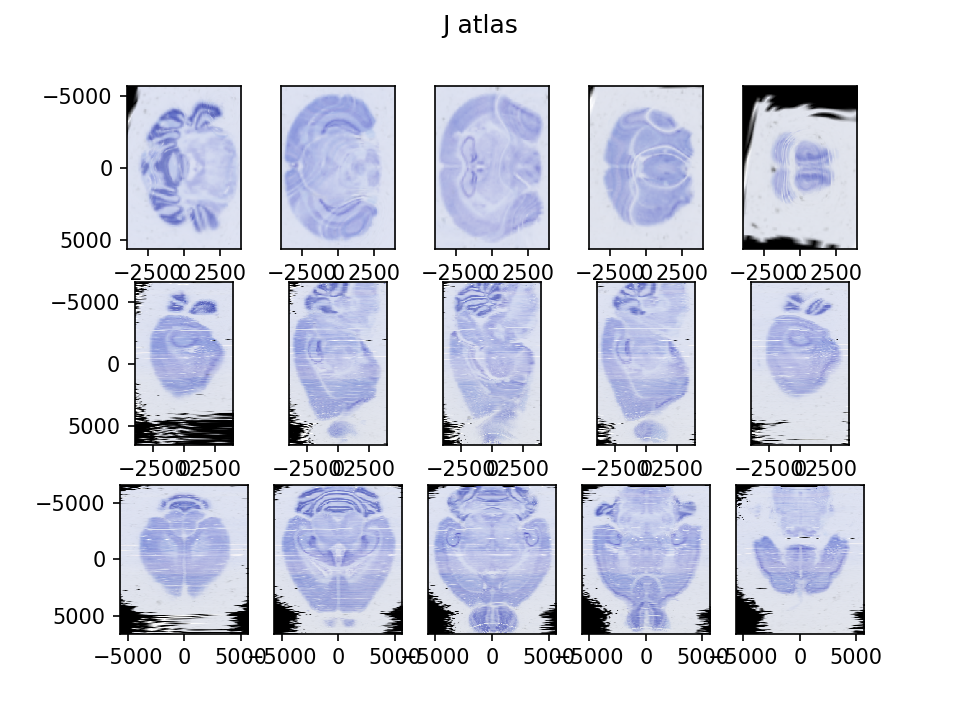

<IPython.core.display.Javascript object>


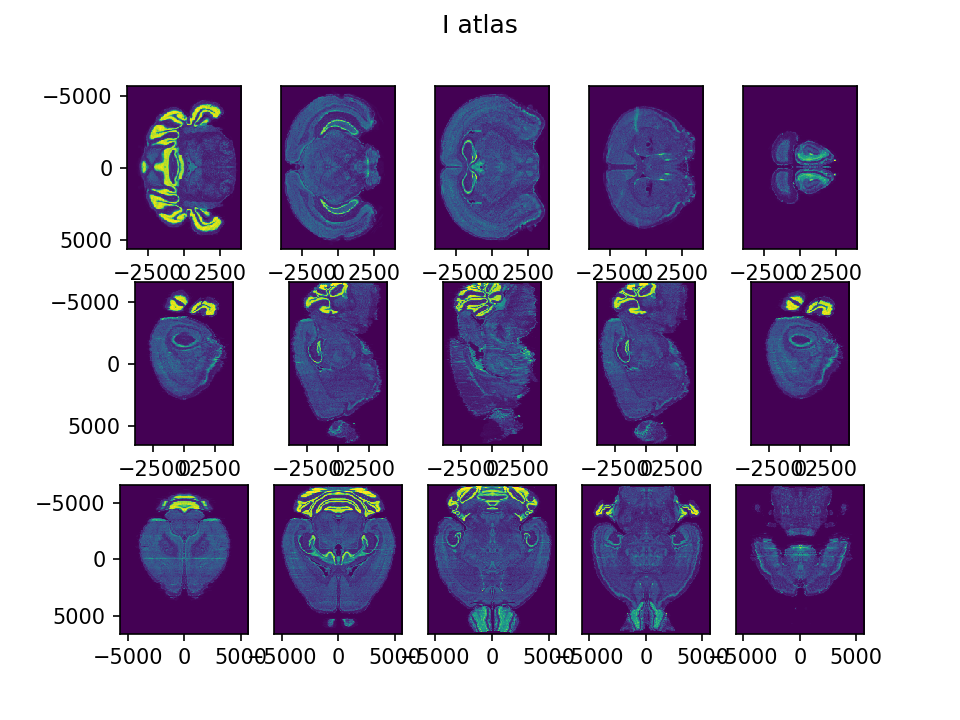

<IPython.core.display.Javascript object>


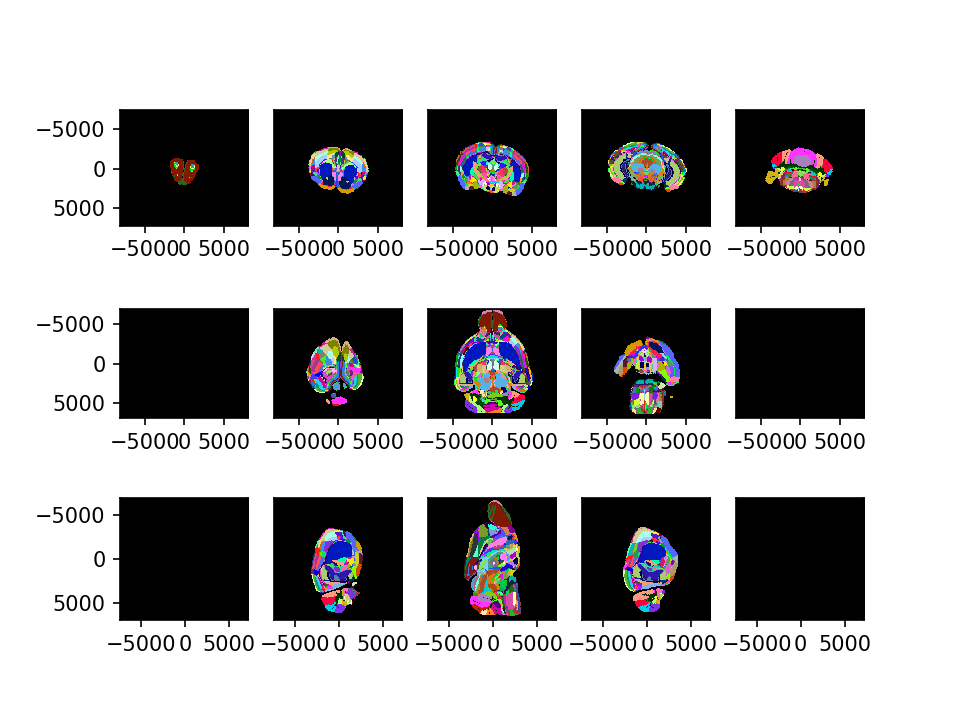

<IPython.core.display.Javascript object>


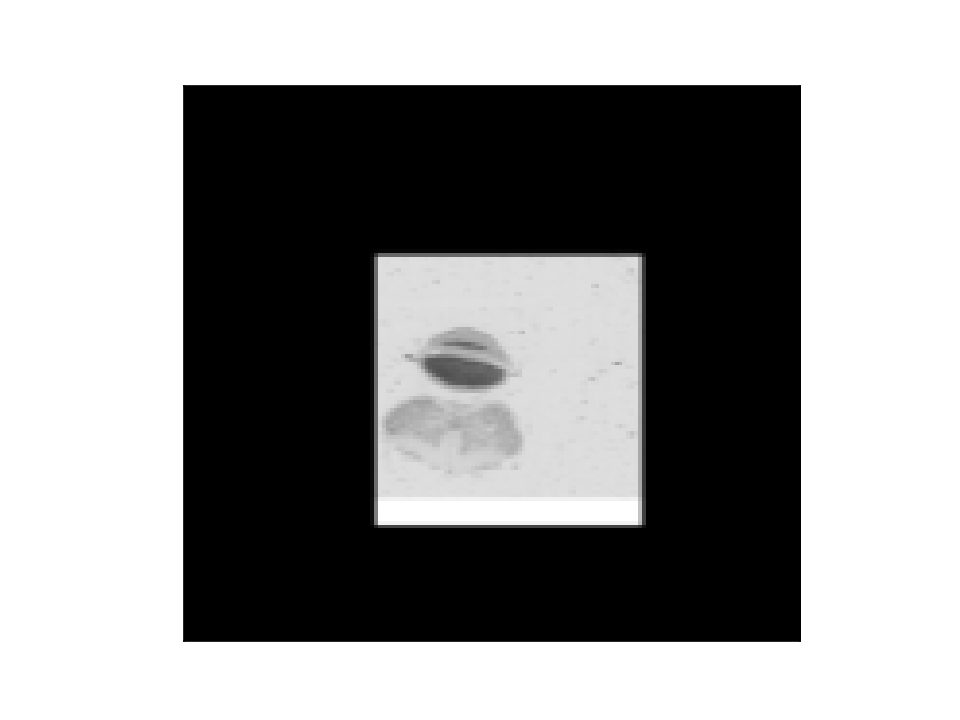

In [21]:
imp.reload(emlddmm)
emlddmm.write_qc_outputs(output_dir,output,xI,I,xJ,J,xS=xI,S=S.astype(np.int32))

<IPython.core.display.Javascript object>


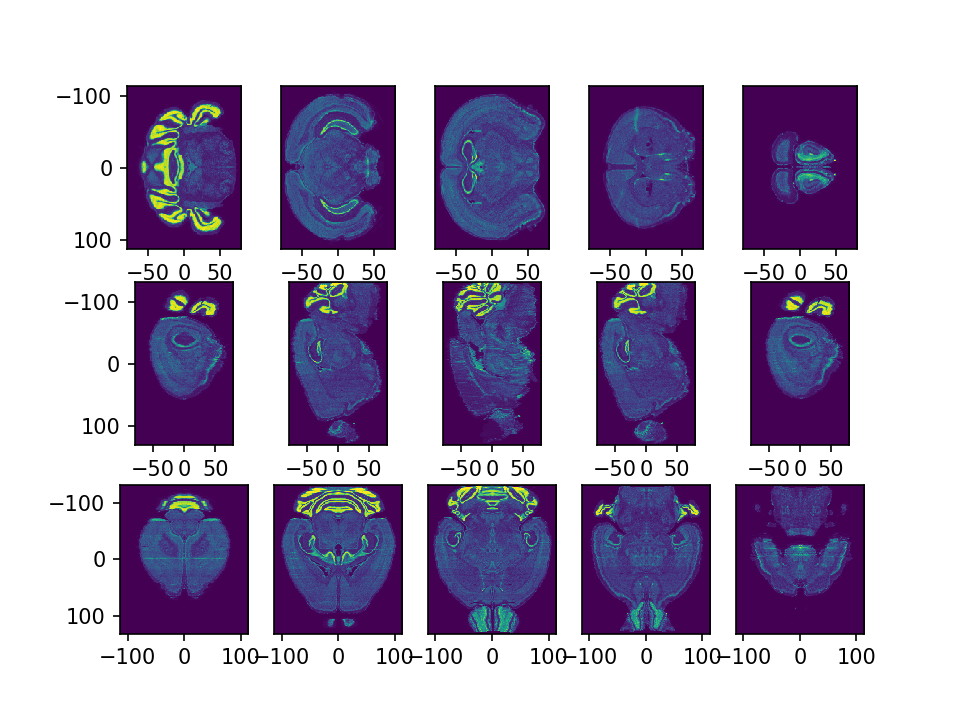

<IPython.core.display.Javascript object>


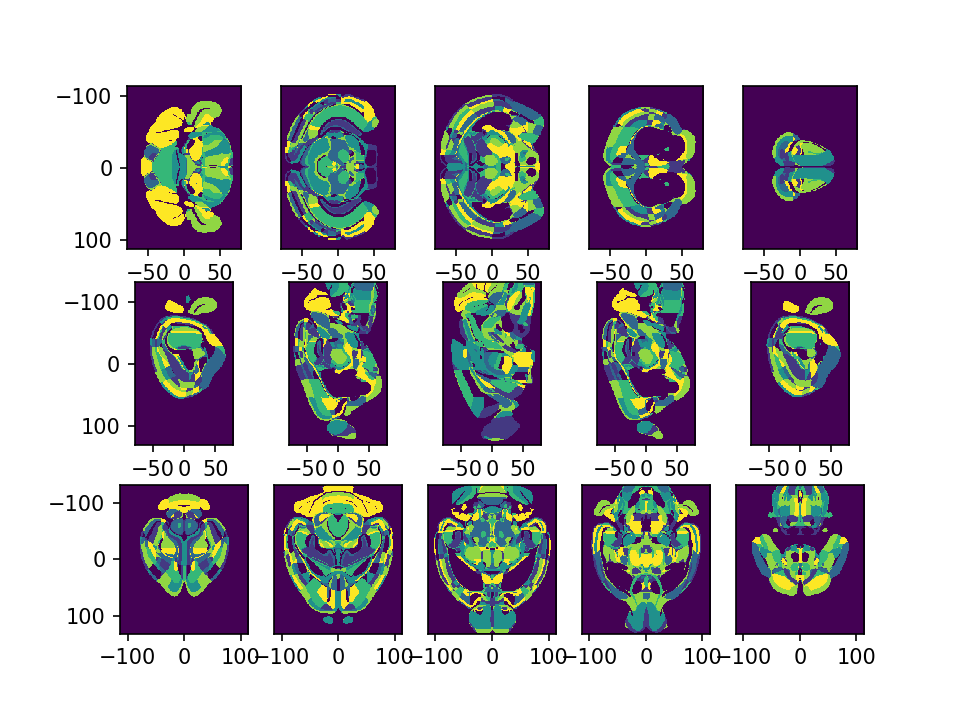

(<Figure size 640x480 with 15 Axes>,
 [[<matplotlib.axes._subplots.AxesSubplot at 0x7f577a67a490>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7f577a2c3510>]])

In [20]:
emlddmm.draw(I)
emlddmm.draw(S%7)

In [ ]:
# low resolution brain volume in registered space for each modality
# low resolution deformed atalas and annotation in registered space.
# and low resolution data in atlas space
# (daniel double check)
#
# things you need for the web interface
# 1. annotations as a geojson file in registered space # include orientation and pixel resolution
# 2. sagittal navigation (text file with mean x mean y mean z)
# 3. A matrix for transforming high resolution images (for portal and for other stuff).
# 4. Grid lines as geojson file
#
# Share with Xu on Monday.
#
# TODO: manual correction
# editing rigid transformation matrices
# we should be able to use the same tool, but we have to test it.
# 
#
#

In [ ]:
# BREGMA shift
# proposal number 1:
# Everything that is being shown on the web needs to be updated
# 1. annotions as a geojson file [all the data in the file will have to be shifted]
# 2. sagittal navigation (all the data in the file will have to be shifted)
# 3. A matrix for transforming high resolution images (the translation part will have to be shifted)
# 4. Grid lines (all the data will have to be shifted)
# 
# proposal number 2 alternative suggestion:
# 1. just display the bregma on the viewer and don't modify any current results.
# 
# proposal number 3:
# 1. keep annotations the same
# 2. shift the sagittal navigation 
# 3. keep transformation matrices the same
# 4. Grid lines, shift the labels not the data
# 


From Xu

Hi Daniel:

Here is what we need:

A low resolution(10 or 50um) brain volume in registered space for each modality: these volumes should have the same dimensions, if one modality has fewer sections compared to another, we can use blank sections to fill the gap.
 
Low resolution deformed atlas and annotation in registered space: also the same dimension as the registered brain volume.

I can only come up with these two right now, Bingxing do you have anything to add?

Sincerely
Xu Li